# 문자 단위의 번역기

##1.  데이터 전처리

1. 필요한 라이브러리 불러오기
2. 데이터 판다스로 불러오기

3. 불필요한 열 삭제하고, 훈련데이터 5만개로 줄이기

4. 디코더에 시작 토큰 \t (<sos>), 종료 토큰 \n (<eos>) 추가하기
5. Tokenizer(단어 사전, 단어장) 생성하기
6. 단어장의 크기를 변수에 담아주기(0번 토큰도 있으므로 +1하기)
7. 영어 데이터, 프랑스어 데이터들의 최대 길이 및 기본 통계 정보 구하기(패딩하기 위해)
8. 프랑스어 데이터, 즉 프랑스어 시퀀스를 2가지 버전(입력 데이터, 출력 데이터)으로 준비

**왜 프랑스어 시퀀스는 2가지 버전으로 나누어 준비?**

- 디코더의 출력과 비교할 정답 데이터로 사용 → <SOS> 토큰 필요 없음
- 교사 강요를 위해 디코더의 입력으로 사용 → <EOS> 토큰 필요 없음

1. 영어 데이터, 프랑스어 입력 데이터, 프랑스어 출력 데이터 각각에 패딩
2. 원핫 인코딩 진행
3. 훈련용 데이터, 검증용 데이터 나누어주기

In [1]:
# 필요 라이브러리 불러오기
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [4]:
# 데이터 판다스로 불러오기

file_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Data/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
34955,The road is closed.,La route est fermée.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
88718,I was too stunned to talk.,Je fus trop abasourdie pour parler.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
95406,He grew a variety of crops.,Il faisait pousser une variété de cultures.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
100728,Tom is playing with my cat.,Tom joue avec mon chat.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
159010,Tom told Mary not to wait for John.,Tom dit à Marie de ne pas attendre John.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [5]:
# 불필요한 열 삭제하고 훈련데이터 5만개로 줄이기
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
12150,No one told me.,Personne ne me le dit.
46871,I know it's not fair.,Je sais que ce n'est pas juste.
48960,Now we'll never know.,"A présent, nous ne saurons jamais."
535,Get lost!,Dégage !
14681,How can that be?,Comment cela se peut-il ?


In [6]:
# 디코더에 시작 토큰, 종료 토큰 추가하기
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 50000


,eng,fra
47523,I was probably wrong.,\t J'avais probablement tort. \n
17034,They're trapped.,\t Ils sont piégés. \n
37461,You've got an hour.,\t Tu as une heure. \n
21099,It can't be done.,\t Ça ne peut pas être fait. \n
22993,Tom won the game.,\t Tom a gagné la partie. \n


In [7]:
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다.
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]
print(input_text)

[[19, 4, 7], [19, 4, 7], [19, 4, 7], [19, 4, 7], [11, 5, 7], [11, 5, 7], [9, 15, 10, 28], [9, 15, 10, 28], [9, 15, 10, 28], [9, 15, 10, 28], [9, 15, 10, 28], [9, 15, 10, 28], [9, 15, 10, 28], [9, 15, 10, 28], [9, 15, 10, 7], [9, 15, 10, 7], [9, 15, 10, 7], [9, 15, 10, 7], [9, 15, 10, 7], [9, 15, 10, 7], [9, 15, 10, 7], [9, 15, 10, 7], [17, 11, 4, 26], [17, 4, 17, 28], [17, 4, 17, 28], [17, 4, 17, 28], [13, 15, 20, 22, 28], [13, 15, 20, 22, 28], [13, 15, 20, 22, 28], [24, 5, 9, 2, 28], [11, 2, 12, 21, 28], [11, 5, 13, 2, 7], [11, 5, 13, 2, 7], [27, 15, 16, 21, 28], [27, 15, 16, 21, 7], [8, 3, 4, 21, 28], [8, 3, 4, 21, 28], [8, 3, 4, 21, 28], [17, 6, 5, 3, 28], [17, 6, 5, 3, 28], [17, 6, 5, 3, 28], [17, 6, 5, 3, 7], [17, 6, 5, 3, 7], [17, 6, 5, 3, 7], [17, 6, 5, 3, 7], [23, 2, 19, 5, 10, 7], [23, 2, 19, 5, 10, 7], [19, 4, 1, 4, 10, 7], [19, 4, 1, 4, 10, 7], [19, 4, 1, 4, 10, 7], [11, 2, 12, 12, 4, 28], [11, 2, 12, 12, 4, 28], [11, 2, 12, 12, 4, 7], [11, 2, 12, 12, 4, 7], [11, 2, 12, 12, 

In [8]:
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다.
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[10, 1, 19, 5, 1, 31, 1, 11],
 [10, 1, 15, 5, 12, 16, 29, 2, 14, 1, 11],
 [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]

In [9]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73


In [10]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 21
프랑스어 시퀀스의 최대 길이 69


In [11]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73
영어 시퀀스의 최대 길이 21
프랑스어 시퀀스의 최대 길이 69


In [12]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text]
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [13]:
print(decoder_input[:3])
print(decoder_target[:3])

[[10, 1, 19, 5, 1, 31, 1], [10, 1, 15, 5, 12, 16, 29, 2, 14, 1], [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1]]
[[1, 19, 5, 1, 31, 1, 11], [1, 15, 5, 12, 16, 29, 2, 14, 1, 11], [1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]


In [14]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21)
프랑스어 입력데이터의 크기(shape) : (50000, 69)
프랑스어 출력데이터의 크기(shape) : (50000, 69)


In [15]:
print(encoder_input[0])

[19  4  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [16]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21, 52)
프랑스어 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 69, 73)


In [17]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 21, 52)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 69, 73)


## 2. 모델 훈련

In [18]:
# 필요 라이브러리 불러오기

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [19]:
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None, eng_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

In [20]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

In [21]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [23]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 52)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 73)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        316416      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

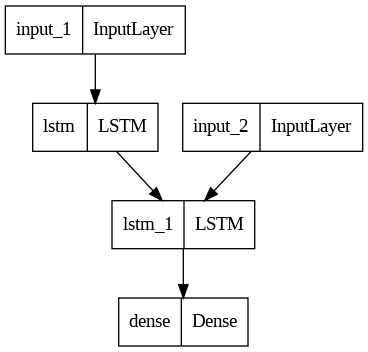

In [24]:
from tensorflow.keras import utils

utils.plot_model(model)

In [27]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=64, epochs=10)

Epoch 1/10
735/735 [==============================] - 234s 318ms/step - loss: 0.3370 - val_loss: 0.4495
Epoch 2/10
735/735 [==============================] - 234s 318ms/step - loss: 0.3275 - val_loss: 0.4427
Epoch 3/10
735/735 [==============================] - 234s 318ms/step - loss: 0.3191 - val_loss: 0.4346
Epoch 4/10
735/735 [==============================] - 233s 317ms/step - loss: 0.3114 - val_loss: 0.4260
Epoch 5/10
735/735 [==============================] - 233s 317ms/step - loss: 0.3045 - val_loss: 0.4186
Epoch 6/10
735/735 [==============================] - 233s 317ms/step - loss: 0.2980 - val_loss: 0.4151
Epoch 7/10
735/735 [==============================] - 233s 317ms/step - loss: 0.2924 - val_loss: 0.4115
Epoch 8/10
735/735 [==============================] - 233s 317ms/step - loss: 0.2869 - val_loss: 0.4064
Epoch 9/10
735/735 [==============================] - 233s 317ms/step - loss: 0.2819 - val_loss: 0.4018
Epoch 10/10
735/735 [==============================] - 233s 317m

## 3. 모델 테스트

In [28]:
# 인코더 정의
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 52)]        0         
                                                                 
 lstm (LSTM)                 [(None, 256),             316416    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 316,416
Trainable params: 316,416
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 디코더 설계

# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [30]:
# 디코더 출력층 재설계

decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 73)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, None, 256),  337920      ['input_2[0][0]',                
                                 (None, 256),                     'input_3[0][0]',          

In [31]:
# 단어에서 정수로, 정수에서 단어로 바꾸는 사전 만들기

eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [32]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [33]:
# 구현한 함수에 번역하고자 하는 문장의 인덱스 입력해서 출력결과 테스트

import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Go.
정답 문장:  Bouge ! 
번역기가 번역한 문장:  parlez-vous ! 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Hello!
정답 문장:  Bonjour ! 
번역기가 번역한 문장:  bouge ! 
1/1 [==============================] - 0s 18ms/step
-----------------------------------
입력 문장: Got it!
정답 문장:  Compris ! 
번역기가 번역한 문장:  pars ! 
1/1 [==============================] - 0s 18ms/step
-----------------------------------
입력 문장: Goodbye.
정답 문장:  Au revoir. 
번역기가 번역한 문장:  consons-nous ! 
1/1 [==============================] - 0s 19ms/step
-----------------------------------
입력 문장: Hands off.
정답 문장:  Pas touche ! 
번역기가 번역한 문장:  attends une bonne ! 


# 단어 Level로 번역기 업그레이드하기
Rubric

|평가문항|상세기준|
|---|---|
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
|2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.|seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.|


- 위 실습에서 구현한 번역기는 글자 단위(chracter-level)에서 구현된 번역기였으나, 실제로는 단어 단위(Word-level)에서 구현되는 것이 더 보편적이다.
- 진행될 프로젝트에서는 동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical()함수가 아닌 임베팅 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시키기
- 단어 단위로 할 경우, 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기도 커지고 학습 속도도 더 느려지게 된다.  따라서 학습과 테스트 시의 원활한 진행을 위해 데이터에서 상위 33,000개의 샘플만 사용하기(

In [34]:
# 필요 라이브러리 불러오기

import tensorflow
print(tensorflow.__version__)

import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

2.12.0


In [35]:
file_path = "/content/drive/MyDrive/Colab Notebooks/AIFFEL/Data/translator_seq2seq/data/fra.txt"
lines = pd.read_csv(file_path, names=["eng", "fra", "cc"], sep="\t")
print("전체 샘플의 수 :",len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
126323,What subject do you like best?,Quel sujet préférez-vous ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
152124,She went to see him the other day.,"Elle est allée le voir, l'autre jour.",CC-BY 2.0 (France) Attribution: tatoeba.org #8...
106804,I'm thankful for technology.,Je suis reconnaissant de pouvoir disposer de l...,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
198955,Thirteen people were killed in the train wreck.,Treize personnes ont été tuées lors de l'accid...,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
25505,I already said no.,J'ai déjà dit non.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


## Step1.정제, 정규화, 전처리(영어, 프랑스어)

In [36]:
# 훈련 데이터는 3.3만개의 샘플로 지정

num_samples = 33000

In [37]:
import re
import unicodedata
# def text_pre_proc_ex(text):
#     text = text.strip()    ## strip() : 인자는 제거할 문자 지정. 지정 하지 않은 기본값은 문자열의 선행 후행 공백 제거
#     text = re.sub(r"[^-,.?!A-zÀ-ú\s]", "", text)    ## 영문자, 구두점과 공백을 제외하고 모두 제거
#     text = text.strip()
#     text = re.sub(r"^ +", "", text)    ## 1칸 초과하는 공백 제거 (첫번째 공백은 유지, 이어서 두번째 부터 공백 나타나면 제거)
#     text = text.strip()
#     return text

def to_ascii(s):
    # 프랑스어 악센트(accent) 삭제
    # 예시 : 'déjà diné' -> deja dine
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
    # 악센트 제거 함수 호출
    sent = to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백 추가.
    # ex) "I am a student." => "I am a student ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    # 소문자로 변경
    sent = sent.lower()

    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)

    return sent

In [38]:
eng_sent = u"Have you had dinner?"
fra_sent = u"Avez-vous déjà diné?"

print("전처리 전 영어 문장 :", eng_sent)
print("전처리 후 영어 문장 :",preprocess_sentence(eng_sent))
print("전처리 전 프랑스어 문장 :", fra_sent)
print("전처리 후 프랑스어 문장 :", preprocess_sentence(fra_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [39]:
def load_preprocessed_data():

    encoder_input, decoder_input, decoder_target = [], [], []

    with open(file_path, "r") as lines:

        for i, line in enumerate(lines):
            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split("\t")

            # source 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [40]:
sents_eng_in, sents_fra_in, sents_fra_out = load_preprocessed_data()

print("인코더의 입력1 :",sents_eng_in[:3])
print()
print("디코더의 입력1 :",sents_fra_in[:3])
print()
print("디코더의 라벨1 :",sents_fra_out[:3])
print()
print()
print("인코더의 입력2 :",sents_eng_in[-3:])
print()
print("디코더의 입력2 :",sents_fra_in[-3:])
print()
print("디코더의 라벨2 :",sents_fra_out[-3:])

인코더의 입력1 : [['go', '.'], ['go', '.'], ['go', '.']]

디코더의 입력1 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!']]

디코더의 라벨1 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>']]


인코더의 입력2 : [['i', 'want', 'to', 'see', 'that', '.'], ['i', 'want', 'to', 'see', 'them', '.'], ['i', 'want', 'to', 'see', 'this', '.']]

디코더의 입력2 : [['<sos>', 'je', 'veux', 'voir', 'ca', '.'], ['<sos>', 'je', 'veux', 'les', 'voir', '.'], ['<sos>', 'je', 'veux', 'voir', 'ceci', '.']]

디코더의 라벨2 : [['je', 'veux', 'voir', 'ca', '.', '<eos>'], ['je', 'veux', 'les', 'voir', '.', '<eos>'], ['je', 'veux', 'voir', 'ceci', '.', '<eos>']]


## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.


예시 : ['courez', '!']

입력 시퀀스 : [' ', 'courez', '!']

레이블 시퀀스 : ['courez', '!', ' ']

## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.


In [41]:
## 정수 인코딩과 패딩 - Eng
tokenizer_eng = Tokenizer(filters="", lower=False)

tokenizer_eng.fit_on_texts(sents_eng_in)
encoder_input = tokenizer_eng.texts_to_sequences(sents_eng_in)
encoder_input = pad_sequences(encoder_input, padding="post")

## 정수 인코딩과 패딩 - Fra
tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [42]:
encoder_input[-5:]

array([[  2,  49,  19, 629,   5,   1,   0],
       [  2,  49,  19,  70, 179,   1,   0],
       [  2,  49,  19,  70,  14,   1,   0],
       [  2,  49,  19,  70, 102,   1,   0],
       [  2,  49,  19,  70,  18,   1,   0]], dtype=int32)

In [43]:
decoder_input[-5:]

array([[  2,   4,  70, 126,   7,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  2,   4,  70,  25, 126, 393,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  2,   4,  70, 126,  29,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  2,   4,  70,  33, 126,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  2,   4,  70, 126, 100,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]], dtype=int32)

In [44]:
decoder_target[-5:]

array([[  4,  70, 126,   7,   1,   3,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  4,  70,  25, 126, 393,   1,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  4,  70, 126,  29,   1,   3,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  4,  70,  33, 126,   1,   3,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  4,  70, 126, 100,   1,   3,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]], dtype=int32)

In [45]:
print("인코더의 입력의 크기(shape) :",encoder_input.shape)
print("디코더의 입력의 크기(shape) :",decoder_input.shape)
print("디코더의 레이블의 크기(shape) :",decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 7)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


In [46]:
eng_vocab_size = len(tokenizer_eng.word_index) + 1
fra_vocab_size = len(tokenizer_fra.word_index) + 1

print("영어 단어장의 크기 :", eng_vocab_size)
print("프랑스어 단어장의 크기 :", fra_vocab_size)

영어 단어장의 크기 : 4516
프랑스어 단어장의 크기 : 7907


In [47]:
max_eng_seq_len = max([len(line) for line in encoder_input])
max_fra_seq_len = max([len(line) for line in decoder_target])

print("영어 시퀀스의 최대 길이 :", max_eng_seq_len)
print("프랑스어 시퀀스의 최대 길이 :", max_fra_seq_len)

영어 시퀀스의 최대 길이 : 7
프랑스어 시퀀스의 최대 길이 : 16


In [48]:
print("전체 샘플의 수 :",len(lines))
print("영어 단어장의 크기 :", eng_vocab_size)
print("프랑스어 단어장의 크기 :", fra_vocab_size)
print("영어 시퀀스의 최대 길이 :", max_eng_seq_len)
print("프랑스어 시퀀스의 최대 길이 :", max_fra_seq_len)

전체 샘플의 수 : 217975
영어 단어장의 크기 : 4516
프랑스어 단어장의 크기 : 7907
영어 시퀀스의 최대 길이 : 7
프랑스어 시퀀스의 최대 길이 : 16


In [49]:
eng2idx = tokenizer_eng.word_index
idx2eng = tokenizer_eng.index_word
fra2idx = tokenizer_fra.word_index
idx2fra = tokenizer_fra.index_word

In [50]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print("np.max(indices) :", np.max(indices))
print("np.min(indices) :", np.min(indices))
print("랜덤 시퀀스 :", indices)

np.max(indices) : 32999
np.min(indices) : 0
랜덤 시퀀스 : [16757  1486 10495 ...  9569 28921 27723]


In [51]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [52]:
print("encoder_input[12345] :", encoder_input[12345])
print("decoder_input[12345] :", decoder_input[12345])
print("decoder_target[12345] :", decoder_target[12345])

encoder_input[12345] : [  6   7   9 358   1   0   0]
decoder_input[12345] : [  2  20   5  24 398   1   0   0   0   0   0   0   0   0   0   0]
decoder_target[12345] : [ 20   5  24 398   1   3   0   0   0   0   0   0   0   0   0   0]


In [53]:
n_of_val = int(3000)
print("검증 데이터의 개수 :", n_of_val)

검증 데이터의 개수 : 3000


In [54]:
# 훈련데이터와 테스트 데이터 분리

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [55]:
print("encoder_input_train.shape :", encoder_input_train.shape)
print("decoder_input_train.shape :", decoder_input_train.shape)
print("decoder_target_train.shape :", decoder_target_train.shape)
print()
print("encoder_input_test.shape :", encoder_input_test.shape)
print("decoder_input_test.shape :", decoder_input_test.shape)
print("decoder_target_test.shape :", decoder_target_test.shape)

encoder_input_train.shape : (30000, 7)
decoder_input_train.shape : (30000, 16)
decoder_target_train.shape : (30000, 16)

encoder_input_test.shape : (3000, 7)
decoder_input_test.shape : (3000, 16)
decoder_target_test.shape : (3000, 16)


## Step 4. 임베딩 층(Embedding layer) 사용하기

- 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화

주의) 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만, 디코더의 훈련 과정과 테스트 과정에서의 임베딩 층은 동일해야 함

## Step 5. 모델 구현하기

In [56]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

embedding_dim = 64
hidden_units = 64

In [57]:
# 인코더 설계

## 입력 텐서. → 입력 문장을 저장하게 될 변수 텐서
encoder_inputs = Input(shape=(None,))

## 인코더용 임베딩 층. 입력텐서가 들어간다.
encoder_embed = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)

## 패딩 (0)을 연산에서 제외.
encoder_mask = Masking(mask_value=0.0)(encoder_embed)

## hidden_units 만큼의 hidden_size 를 가지는(LSTM 의 수용력을 의미) LSTM 셀을 만든다.
## return_state=True 지정 → hidden state & cell state 를 리턴 받을 수 있도록 한다.
encoder_lstm = LSTM(units=hidden_units, return_state=True)

## 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_mask)

## 인코더의 hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
## → 디코더에 전달
encoder_states = [state_h, state_c]

In [58]:
# 디코더 설계

## 입력 텐서
decoder_inputs = Input(shape=(None,))

## 디코더용 임베딩 층. 입력텐서가 들어간다.
decoder_embed_layer = Embedding(fra_vocab_size, hidden_units)
decoder_embed = decoder_embed_layer(decoder_inputs)

## 패딩 (0)을 연산에서 제외.
decoder_mask = Masking(mask_value=0.0)(decoder_embed)

## hidden_units 만큼의 hidden_size 를 가지는(LSTM 의 수용력을 의미) LSTM 셀을 만든다.
## 모든 시점에 대해서 단어를 예측하기 위해 return_sequences=True 지정.
## 상태값 리턴을 위해 return_state=True 지정.
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

## 디코더 LSTM 셀의 초기 은닉 상태(initial_state)에 인코더에서의 은닉 상태를 사용하도록 지정
## → 이전에 저장한 인코더의 마지막 time step 의 hidden state & cell state 를 LSTM 셀의 초기 상태로
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=encoder_states)

## 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
## Dense의 인자로 프랑스어 단어장의 크기. 활성화 함수로는 소프트맥스 함수 지정.
## → seq2seq 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고 있다.
## 　 매 time step마다의 다중 클래스 분류 문제이므로,
## 　 프랑스어 단어 집합의 크기(fra_vocab_size)의 선택지으로부터 1개 단어 선택하도록 구성.
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [59]:
## 인코더와 디코더를 연결
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [60]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     289024      ['input_5[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     506048      ['input_6[0][0]']                
                                                                                            

In [61]:
# 모델 훈련
trans_hist = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 90s 355ms/step - loss: 3.3685 - acc: 0.6134 - val_loss: 2.0544 - val_acc: 0.6169
Epoch 2/50
235/235 [==============================] - 91s 387ms/step - loss: 1.8609 - acc: 0.6669 - val_loss: 1.7532 - val_acc: 0.7368
Epoch 3/50
235/235 [==============================] - 91s 386ms/step - loss: 1.6432 - acc: 0.7459 - val_loss: 1.5912 - val_acc: 0.7507
Epoch 4/50
235/235 [==============================] - 90s 381ms/step - loss: 1.5025 - acc: 0.7595 - val_loss: 1.4783 - val_acc: 0.7590
Epoch 5/50
235/235 [==============================] - 93s 397ms/step - loss: 1.4077 - acc: 0.7677 - val_loss: 1.4024 - val_acc: 0.7713
Epoch 6/50
235/235 [==============================] - 91s 388ms/step - loss: 1.3279 - acc: 0.7842 - val_loss: 1.3340 - val_acc: 0.7886
Epoch 7/50
235/235 [==============================] - 92s 392ms/step - loss: 1.2591 - acc: 0.7949 - val_loss: 1.2768 - val_acc: 0.7940
Epoch 8/50
235/235 [==============================] - 8

In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
def hist_plot(history:tf.keras.callbacks.History()):

    tacc = history.history["acc"]
    vacc = history.history["val_acc"]

    tloss=history.history["loss"]
    vloss=history.history["val_loss"]

    epochs_range = range(50)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, tacc, label="Training Accuracy")
    plt.plot(epochs_range, vacc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, tloss, label="Training Loss")
    plt.plot(epochs_range, vloss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

    plt.show()

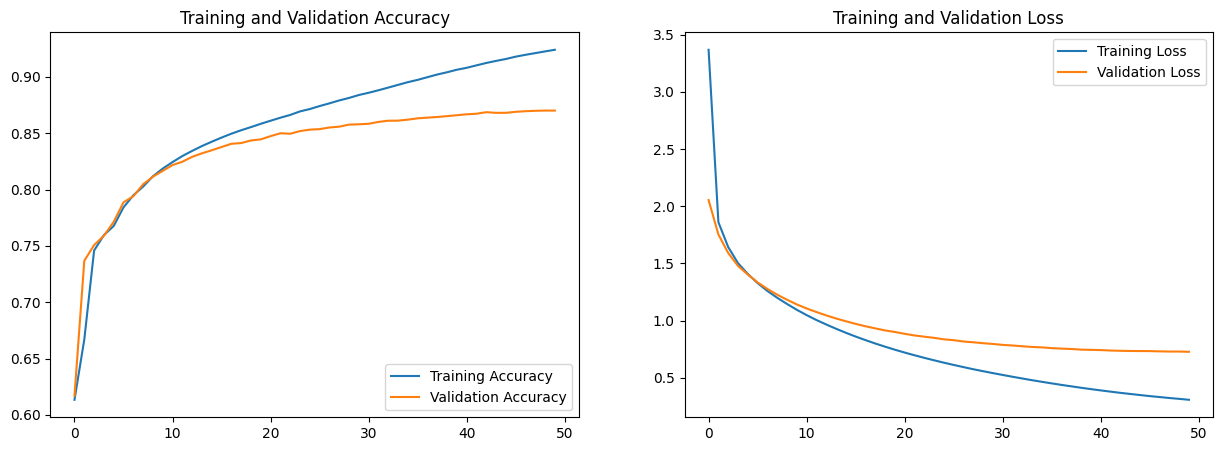

In [63]:
# 훈련 결과 출력
hist_plot(trans_hist)

## Step 6. 모델 평가하기

평가를 위해 모델 재설계

In [64]:
## 인코더 모델의 경우 기존에 정의를 재사용
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          289024    
                                                                 
 masking (Masking)           (None, None, 64)          0         
                                                                 
 lstm_2 (LSTM)               [(None, 64),              33024     
                              (None, 64),                        
                              (None, 64)]                        
                                                                 
Total params: 322,048
Trainable params: 322,048
Non-trainable params: 0
_________________________________________________________________


In [66]:
# 디코더
## 이전 time step 에서의 …
## … hidden state를 저장하는 텐서 …
decoder_state_input_h = Input(shape=(hidden_units,))
## … cell state를 저장하는 텐서 …
decoder_state_input_c = Input(shape=(hidden_units,))
## …를 묶어서 하나의 변수로
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

## 테스트 단계에서는 디코더를 매 시점 별로 컨트롤 할 예정으로, 이를 위해서
## 이전 시점의 상태를 저장할 텐서인
## decoder_state_input_h, decoder_state_input_c 를 정의.
## 매 시점 별로 디코더를 컨트롤하는 함수는
## 뒤에서 정의할 decode_sequence() 를 살펴보아야 한다.


## 훈련 때 사용했던 임베딩 층을 재사용
decoder_embed_layer2 = decoder_embed_layer(decoder_inputs)

## 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
## → decoder_states_inputs 을 현재 time step의 초기 상태로 사용.
## （구체적인 동작 자체는 def decode_sequence()에 구현.）
decoder_outputs2, state_h2, state_c2 = \
    decoder_lstm(decoder_embed_layer2, initial_state=decoder_states_inputs)

## 현재 time step의 hidden state 와 cell state를 하나의 변수에 저장
decoder_states2 = [state_h2, state_c2]

In [67]:
## 수정된 디코더 - 디코더 재설계
decoder_model = \
    Model(inputs=[decoder_inputs] + decoder_states_inputs,
          outputs=[decoder_outputs2] + decoder_states2)

decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     506048      ['input_6[0][0]']                
                                                                                                  
 input_9 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [68]:
def decode_sequence(input_seq):

    ## ① 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    ## 이 두개의 값을 ② states_value 에 할당
    states_value = encoder_model.predict(input_seq)

    ## ③ 디코더의 초기 입력으로 <sos>에 해당하는 정수 생성
    ## 이를 ④ target_seq 에 할당
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx["<sos>"]    ## <sos>에 해당하는 정수

    ## while 루프에 사용
    stop_condition = False

    ## 반환값이 될 변수. 일단 빈 문자열로 지정.
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:

        ## ※ 중요
        ## ②, ④ 두개의 값을 디코더의 입력으로 사용
        ## 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        ## ⑤ output_tokens：현 시점의 예측 벡터
        ## ⑥ h：현시점의 은닉 상태
        ## ⑦ c：현시점의 셀 상태
        output_tokens, h, c = \
            decoder_model.predict([target_seq] + states_value)

        ## 아래에서는
        ## ⑤ output_tokens 의 예측 벡터로부터,
        ## 현재 시점의 예측 단어인 ④ target_seq 를 얻는다.
        ## 그리고…
        ## ⑥ h：현시점의 은닉 상태, ⑦ c：현시점의 셀 상태 를 통해
        ## 현재시점의 ② states_value 를 만들어
        ## 다음 루프(시점)의 디코더 모델의 입력으로 사용할 것이다.

        ## 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2fra[sampled_token_index]

        ## 도중 <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_word == "<eos>"):
            stop_condition = True
            break

        ## 현재 시점의 예측 단어를 예측 문장에 추가.
        ## 각 시점마다 번역된 단어는
        ## ⑧ decoded_sentence 에 누적하여 저장하였다가
        ## 루프를 빠져 나오면, 「최종 번역 시퀀스 값」으로 리턴된다.
        decoded_sentence += " " + sampled_word

        ## 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        ## 여기의 ④ target_seq 는, 다음 루프 시점의 디코더에 입력으로 사용될 것이다

        ## 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        ## ⑥ h：현시점의 은닉 상태, ⑦ c：현시점의 셀 상태 는
        states_value = [h, c]
        ## 다시 ② states_value 에 할당되어,
        ## 바로 위의 ④ target_seq 와 함께,
        ## 다음 루프 시점의 디코더에 입력으로 사용된다.

    return decoded_sentence.strip()

In [69]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_eng(input_seq):
    sentence = ""
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + idx2eng[encoded_word] + " "
    return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_fra(input_seq):
    sentence = ""
    for encoded_word in input_seq:
        if(encoded_word != 0 and
           encoded_word != fra2idx["<sos>"] and
           encoded_word != fra2idx["<eos>"]):
            sentence = sentence + idx2fra[encoded_word] + " "
    return sentence

In [71]:
!pip install googletrans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15721 sha256=d09eda0856617a52db0ce3ad32035d1228c2f2bb0fa4576a35c0e025018faf91
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  

In [72]:
import googletrans
from googletrans import Translator
print(googletrans.__version__)
translator = \
    Translator(service_urls=
               ["translate.google.co.kr",])

3.0.0


In [ ]:
# 훈련 데이터의 샘플 5개 랜덤 추출

for seq_index in np.random.randint(30000, size=5):
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("seq_index :", seq_index)
    print("입력문장 :", seq_to_eng(encoder_input_train[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_train[seq_index]))
    print("번역문장 :", decoded_sentence)
    print("─" * 64)

In [ ]:
# 테스트 데이터의 샘플 5개 랜덤 추출

for seq_index in np.random.randint(3000, size=5):
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("seq_index :", seq_index)
    print("입력문장 :", seq_to_eng(encoder_input_test[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_test[seq_index]))
    print("번역문장 :", decoded_sentence)
    print("─" * 64)

## 회고

## Reference

- LSTM (https://simpling.tistory.com/19), (https://wikidocs.net/106473)
- https://lsjsj92.tistory.com/m/449
- 케라스 임베딩 레이어 사용 (https://wikidocs.net/33793)